In [1]:
#!pip install patsy

In [2]:
import lda
import patsy
import pandas as pd
import numpy as np
import bokeh.plotting as bp
from datetime import timedelta
from sklearn import decomposition
from sklearn import feature_extraction
from sklearn.manifold import TSNE
from bokeh.models import HoverTool
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
games = pd.read_csv("FinalResults.csv",
                    encoding = "latin", header = None, 
                    names = ["sentiment", "hashtag", "week", "matchup", "kickoff", "tweetID", "tweet_time", "location", "verified", "text"], 
                    dtype={"sentiment": str, "hashtag": str, "week": str, "matchup": str, "tweetID": np.dtype("int64"),
                          "location": str, "verified": str, "text": str})
games.kickoff =  pd.to_datetime(games.kickoff, infer_datetime_format = True)
games.tweet_time =  pd.to_datetime(games.tweet_time, infer_datetime_format = True)

In [4]:
bins = []
for row in games.itertuples():
    if row.kickoff - row.tweet_time <= timedelta(hours = 1):
        bins.append(0)
    elif row.kickoff - row.tweet_time <= timedelta(hours = 4):
        bins.append(1)
    elif row.kickoff - row.tweet_time <= timedelta(hours = 10):
        bins.append(2)
    elif row.kickoff - row.tweet_time <= timedelta(hours = 24):
        bins.append(3)
    else:
        bins.append(4)
bin_col = pd.Series(bins)
games["time_bin"] = bin_col.values

In [5]:
#temp = games.drop_duplicates(subset = "text", keep = "first")
#tweets_text = temp.text.values
tweets_text = games.text.values
tweets_text = [' '.join(filter(unicode.isalpha, raw.lower().split())) for raw in tweets_text]

In [6]:
# Create a CountVectorizer for parsing/counting words
count_vectorizer = feature_extraction.text.CountVectorizer(
    ngram_range=(1, 1),
    stop_words='english',
    token_pattern="\\b[a-z][a-z]+\\b",
    min_df=1,
)
cvz = count_vectorizer.fit_transform(tweets_text[:100])

In [7]:
#corpus = matutils.Sparse2Corpus(cvz)
#id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [8]:
lda_model = lda.LDA(n_topics = 20, n_iter = 1000)
x_topics = lda_model.fit_transform(cvz);

#lda_model = models.LdaModel(corpus=corpus, num_topics=5, id2word=id2word, passes=10)

INFO:lda:n_documents: 100
INFO:lda:vocab_size: 179
INFO:lda:n_words: 543
INFO:lda:n_topics: 20
INFO:lda:n_iter: 1000
/home/ubuntu/miniconda3/lib/python3.6/site-packages/lda/utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):
INFO:lda:<0> log likelihood: -5539
INFO:lda:<10> log likelihood: -3028
INFO:lda:<20> log likelihood: -2950
INFO:lda:<30> log likelihood: -2935
INFO:lda:<40> log likelihood: -2838
INFO:lda:<50> log likelihood: -2779
INFO:lda:<60> log likelihood: -2818
INFO:lda:<70> log likelihood: -2837
INFO:lda:<80> log likelihood: -2800
INFO:lda:<90> log likelihood: -2838
INFO:lda:<100> log likelihood: -2795
INFO:lda:<110> log likelihood: -2795
INFO:lda:<120> log likelihood: -2826
INFO:lda:<130> log likelihood: -2774
INFO:lda:<140> log likelihood: -2835
INFO:lda:<150> log likelihood: -2873

In [9]:
#lda_corpus = lda_model[corpus]
#lda_docs = [doc for doc in lda_corpus]

In [10]:
#lda_model.print_topics()

In [11]:
#threshold = 0.2
#_idx = np.amax(x_topics, axis=1) > threshold  # idx of doc that above the threshold
#x_topics = x_topics[_idx]

In [12]:
#lda_docs[0][1][1]
#x_topics = [[item[i][1] for i in range(len(item))] for item in lda_docs]

In [13]:
x_topics.shape

(100, 20)

In [14]:
tsne_model = TSNE(n_components = 2, verbose = 1, perplexity = 50)
tsne_lda = tsne_model.fit_transform(x_topics);

[t-SNE] Computing 99 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.069s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.454613
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.535526
[t-SNE] Error after 1000 iterations: 0.112974


In [15]:
#Might require NMR
#import matplotlib.pyplot as plt
#plt.figure(figsize=(20,20))
#plt.scatter(tsne_lda.T[0],tsne_lda.T[1],c=x_topics,alpha=1,cmap=plt.cm.get_cmap('tab20_r', 20))
#plt.legend()

In [16]:
n_top_words = 5 # number of keywords we show

# 20 colors
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"
])

In [17]:
_lda_keys = []
for i in range(x_topics.shape[0]):
    _lda_keys +=  x_topics[i].argmax(),

In [18]:
topic_summaries = []
topic_word = lda_model.topic_word_  # all topic words
vocab = count_vectorizer.get_feature_names()
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words + 1):-1] # get!
    topic_summaries.append(' '.join(topic_words)) # append!

In [19]:
title = 'Test Visualization'
num_example = len(x_topics)

plot_lda = bp.figure(plot_width=1400, plot_height=1100,
                     title=title,
                     tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)

plot_lda.scatter(x=tsne_lda[:, 0], y=tsne_lda[:, 1],
                 color=colormap[_lda_keys][:num_example],
)
"""
                 source=bp.ColumnDataSource({
                   "content": tweets_text[:num_example],
                   "topic_key": _lda_keys[:num_example]
                   })""";

In [20]:
topic_coord = np.empty((x_topics.shape[1], 2)) * np.nan
for topic_num in _lda_keys:
    if not np.isnan(topic_coord).any():
        break
    topic_coord[topic_num] = tsne_lda[_lda_keys.index(topic_num)]

# plot crucial words
#for i in range(x_topics.shape[1]):
#    plot_lda.text(topic_coord[i, 0], topic_coord[i, 1], [topic_summaries[i]])

# hover tools
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "@content - topic: @topic_key"}

# save the plot
bp.save(plot_lda, '{}.html'.format(title));

/home/ubuntu/miniconda3/lib/python3.6/site-packages/bokeh/io/saving.py:123: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/home/ubuntu/miniconda3/lib/python3.6/site-packages/bokeh/io/saving.py:136: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


In [21]:
from __future__ import print_function
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [22]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [23]:
n_features = 1000
n_topics = 5
n_top_words = 20
#perc = int(len(tweets_text)/50)
perc = 5

In [24]:
# Use tf-idf features for NMF.
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=perc,
                                   max_features=n_features,
                                   stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(tweets_text)

nmf = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topic #0: alshon jeffery contract signed extension wr worth gets locking key source deal perfect active new antonio brown year sign continue
Topic #1: happy wish rt qb far favorite win knit enter field aaron rodgers giving away chance micro fam christmas appreciate return
Topic #2: look robin brenton thwaites costume upcoming play pic holy really like looks thank dick new throwing series win grayson live
Topic #3: game day week vs ready win time nfl watch today night play sunday tonight field good football live big team
Topic #4: support eagles shoes charitable wearing staff coaches foundation custom ran cool tonight thanks continue home need away gold post win



In [25]:
nmf = NMF(n_components=n_topics, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topic #0: wr jeffery signed alshon extension contract active brown gets antonio rb key ab limited ty roster sign source injured place
Topic #1: qb rt happy wish field win aaron favorite rodgers return chance player away far practice christmas make giving start officially
Topic #2: look play today sunday just live cb robin new pregame like going fans make brenton te love thwaites looks throwing
Topic #3: game vs time nfl ready night watch day season football got retweet pick best team games big good hours know
Topic #4: week win support tonight gameday eli need burgundy players did manning white eagles officially playoff black handled jerseys agree green



In [33]:
more_stops = ["Buffalo", "Miami", "New England", "New York", "Baltimore",
"Cincinnati", "Cleveland", "Pittsburgh", "Houston", "Indianapolis",
"Jacksonville", "Tennessee", "Denver", "Kansas City", "Los Angeles",
"Dallas", "Philadelphia", "Washington", "Chicago", "Detroit",
"Green Bay", "Minnesota", "Atlanta", "Carolina", "New Orleans"
"Tampa Bay", "Arizona", "San Francisco", "Seattle", "Oakland", "bills", "dolphins", "patriots", "jets", "ravens", "bengals", "browns", "steelers",
"texans", "colts", "jaguars", "titans", "broncos", "chiefs", "chargers", "radiers",
"cowboys", "giants", "eagles", "redskins", "bears", "lions", "packers", "vikings",
"falcons", "panthers", "saints", "buccaneers", "cardinals", "rams", "49ers", "seahawks"]

In [36]:
from sklearn.feature_extraction import text
# Use tf (raw term count) features for LDA.
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=perc,
                                max_features=n_features,
                                stop_words=text.ENGLISH_STOP_WORDS.union(more_stops))

tf = tf_vectorizer.fit_transform(tweets_text)

lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.)
new_model = lda.fit_transform(tf)

tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Topic #0: vs tonight live brown football antonio just burgundy nfl monday watch worth sunday dallas big need field aaron ab rb
Topic #1: rt week win thursday eli games geno ready getting day did agree smith retweet members injury ownership handled arriving practice
Topic #2: wr signed extension contract play wish look time today source active team gets going new season pick te rb nfc
Topic #3: alshon jeffery game qb night manning coach good got lee ct video head cleats jimmy locking close practiced decision ty
Topic #4: happy cb fans sean make best guys marshon players want right rush wear black beat dress color away giving josh



In [37]:
matchups = pd.read_csv("Matchups.csv", header = None,
                    names = ["week", "matchup", "away", "home", "kickoff", "winner", "score", "spread"], 
                    dtype={"week": str, "matchup": str, "away": str, "home": str, "winner": str, "score": str, "spread": np.dtype("float64")})
matchups.kickoff =  pd.to_datetime(matchups.kickoff, infer_datetime_format = True)

In [38]:
hashtagger = lambda x: "#" + x.split()[-1].lower()
matchups["away"] = matchups["away"].apply(hashtagger)
matchups["home"] = matchups["home"].apply(hashtagger)
matchups["winner"] = matchups["winner"].apply(hashtagger)

In [39]:
teams = matchups["away"].values.tolist()
teams.extend(matchups["home"].values.tolist())
teams = (set(teams))

In [40]:
topics = []
for item in new_model:
    max_ind = argmax(item)
    if item[max_ind] < 0.1:
        max_ind = -1
    topics.append(max_ind)
topic_col = pd.Series(topics)
games["topic"] = topic_col.values

In [41]:
matchups.head()

,week,matchup,away,home,kickoff,winner,score,spread
0,Week 12,CLEvsCIN,#browns,#bengals,2017-11-26 18:00:00,#bengals,16-30,-7.5
1,Week 12,TENvsIND,#titans,#colts,2017-11-26 18:00:00,#titans,20-16,-3.0
2,Week 12,CHIvsPHI,#bears,#eagles,2017-11-26 18:00:00,#eagles,3-31,-14.0
3,Week 12,CARvsNYJ,#panthers,#jets,2017-11-26 18:00:00,#panthers,35-27,-5.5
4,Week 12,MIAvsNE,#dolphins,#patriots,2017-11-26 18:00:00,#patriots,17-35,-17.0


In [42]:
games.shape

(210037, 12)

In [43]:
teams_only = games.loc[games["hashtag"].isin(teams)]

In [44]:
teams_only.head()

,sentiment,hashtag,week,matchup,kickoff,tweetID,tweet_time,location,verified,text,time_bin,topic
0,Positive,#browns,Week 12,CLEvsCIN,2017-11-26 18:00:00,934844176029704193,2017-11-26 17:59:54,"Elyria, OH",False,b'@ScottPetrak Duh! Lets go #Browns 26-13',0,2
1,Positive,#browns,Week 12,CLEvsCIN,2017-11-26 18:00:00,934844159847890945,2017-11-26 17:59:50,NaN,False,b'RT @MaryKayCabot: Josh Gordon instantly beca...,0,4
2,Positive,#browns,Week 12,CLEvsCIN,2017-11-26 18:00:00,934844156157022208,2017-11-26 17:59:50,Ohio,False,b'This would make me think Coach is safe Hopef...,0,4
3,Negative,#browns,Week 12,CLEvsCIN,2017-11-26 18:00:00,934844136917790720,2017-11-26 17:59:45,"Cincinnati, OH",False,b'6-10 starts today. #Browns',0,1
4,Positive,#browns,Week 12,CLEvsCIN,2017-11-26 18:00:00,934844122267095041,2017-11-26 17:59:41,NaN,False,b'RT @nflstreamg: #Bengals Vs #Browns Live Str...,0,0


In [45]:
def generate_game_freqs(n_topics, teams_only, matchups):
    games_freq = []
    for row in matchups.itertuples():
        freqs = []
        if (row.away == "#browns" and row.week == "Week 12"): #not enough tweets collected this week
            continue
        temp_game = teams_only.loc[teams_only["matchup"] == row.matchup]
        count_temp = temp_game.groupby(["hashtag", "topic", "time_bin", "sentiment"]).count()
        game_teams = count_temp.reset_index().hashtag.unique().tolist()
        if row.winner == row.home:
            freqs.append("home")
        else:
            freqs.append("away")
        for team in game_teams:
            for topic in range (n_topics):
                for tbin in range (5):
                    pos = count_temp.query('hashtag == @team and topic == @topic and time_bin == @tbin and sentiment == "Positive"')
                    neg = count_temp.query('hashtag == @team and topic == @topic and time_bin == @tbin and sentiment == "Negative"')
                    if pos.empty:
                        freqs.append(0.0)
                    elif neg.empty:
                        freqs.append(1.0)
                    else:
                        pos = pos.iloc[0].week
                        neg = neg.iloc[0].week
                        freqs.append(pos/(pos + neg))
        games_freq.append(freqs)
    return games_freq

In [51]:
def get_topics(n_topics, tweets_text):
    # Use tf (raw term count) features for LDA.
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=perc,
                                max_features=n_features,
                                stop_words=text.ENGLISH_STOP_WORDS.union(more_stops))

    tf = tf_vectorizer.fit_transform(tweets_text)

    lda = LatentDirichletAllocation(n_components=n_topics, max_iter=10,
                                    learning_method='online',
                                    learning_offset=50.)
    new_model = lda.fit_transform(tf)

    return new_model

In [47]:
def apply_topics(new_model, new_games):
    topics = []
    for item in new_model:
        max_ind = argmax(item)
        if item[max_ind] < 0.1:
            max_ind = -1
        topics.append(max_ind)
    topic_col = pd.Series(topics)
    new_games["topic"] = topic_col.values
    return new_games

In [48]:
from sklearn.neural_network import MLPClassifier
import sklearn.utils

In [58]:
def predict_nn(df_game):
    temp_df = sklearn.utils.shuffle(df_game)
    Y = temp_df[0]
    X = temp_df.drop(0, axis = 1)
    test_acc = 0
    train_acc = 0
    clf = MLPClassifier(hidden_layer_sizes=(3, 2), activation='logistic', solver='lbfgs', max_iter = 10, warm_start = False)
    clf.classes_ = ["home", "away"]
    clf.fit(X[:11], Y[:11])
    train = clf.predict(X[:11]).tolist()
    test = clf.predict(X[11:]).tolist()
    clf.fit(X[11:], Y[11:])
    train.extend(clf.predict(X[11:]).tolist())
    test.extend(clf.predict(X[:11]).tolist())
    real = Y.tolist()
    for i in range(len(real)):
        if real[i] == train[i]:
            train_acc += 1
        if real[i] == test[i]:
            test_acc += 1
    return train_acc/22, test_acc/22

In [62]:
train_acc = []
test_acc = []
for n_topics in range(2,50):
    print (n_topics)
    new_games = games.copy(deep = True)
    new_games = apply_topics(get_topics(n_topics, tweets_text), new_games)
    teams_only = new_games.loc[new_games["hashtag"].isin(teams)]
    df_game = pd.DataFrame(generate_game_freqs(n_topics, teams_only, matchups))
    df_game.dropna(inplace = True)
    temp_train = []
    temp_test = []
    for i in range(0, 10):
        results = predict_nn(df_game)
        temp_train.append(results[0])
        temp_test.append(results[1])
    train_acc.append(np.mean(temp_train))
    test_acc.append(np.mean(temp_test))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [142]:
test_acc[0:20]

[]

In [88]:
#train_acc

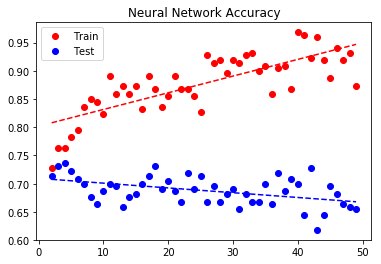

In [109]:
import matplotlib.pyplot as plt
x_points = [i for i in range(2,50)]
plt.plot(x_points, train_acc, 'ro')
plt.plot(x_points, test_acc, 'bo')
z_train = numpy.polyfit(x_points, train_acc, 1)
p_train = numpy.poly1d(z_train)
plt.plot(x_points,p_train(x_points),"r--")
z_test = numpy.polyfit(x_points, test_acc, 1)
p_test = numpy.poly1d(z_test)
plt.plot(x_points,p_test(x_points),"b--")
plt.legend(["Train", "Test"])
plt.title("Neural Network Accuracy")
#plt.figure(figsize = (20, 20))
plt.savefig("accuracies.png", figsize = (30, 30))
plt.show()

In [ ]:
count_temp = temp_game.groupby(["hashtag", "topic", "time_bin", "sentiment"]).count()

In [ ]:
count_temp.head() #handle non-existance of parameter set

In [ ]:
#count_temp.reset_index(inplace = True)
ha = "#bengals"
example = count_temp.query('hashtag == @ha and topic == 0 and time_bin == 0 and sentiment == "Positive"')
example.iloc[0].week

In [ ]:
game_teams = count_temp.reset_index().hashtag.unique().tolist()

In [ ]:
freqs = []
for team in game_teams:
    for topic in range (n_topics):
        for tbin in range (5):
            pos = count_temp.query('hashtag == @team and topic == @topic and time_bin == @tbin and sentiment == "Positive"')
            neg = count_temp.query('hashtag == @team and topic == @topic and time_bin == @tbin and sentiment == "Negative"')
            if pos.empty:
                freqs.append(0.0)
            elif neg.empty:
                freqs.append(1.0)
            else:
                pos = pos.iloc[0].week
                neg = neg.iloc[0].week
                freqs.append(pos/(pos + neg))            

In [ ]:
example.iloc[0].week

In [ ]:
len(freqs)

In [1]:
#http://scikit-learn.org/stable/modules/neural_networks_supervised.html

In [113]:
from sklearn.metrics import confusion_matrix

In [117]:
def predict_nn_cm(df_game):
    temp_df = sklearn.utils.shuffle(df_game)
    Y = temp_df[0]
    X = temp_df.drop(0, axis = 1)
    test_acc = 0
    train_acc = 0
    clf = MLPClassifier(hidden_layer_sizes=(3, 2), activation='logistic', solver='lbfgs', max_iter = 10, warm_start = False)
    clf.classes_ = ["home", "away"]
    clf.fit(X[:11], Y[:11])
    train = clf.predict(X[:11]).tolist()
    test = clf.predict(X[11:]).tolist()
    clf.fit(X[11:], Y[11:])
    train.extend(clf.predict(X[11:]).tolist())
    test.extend(clf.predict(X[:11]).tolist())
    real = Y.tolist()
    for i in range(len(real)):
        if real[i] == train[i]:
            train_acc += 1
        if real[i] == test[i]:
            test_acc += 1
    return confusion_matrix(real, test, labels = ["home", "away"])

In [160]:
train_acc = []
test_acc = []
for n_topics in range(18,19):
    print (n_topics)
    new_games = games.copy(deep = True)
    new_games = apply_topics(get_topics(n_topics, tweets_text), new_games)
    teams_only = new_games.loc[new_games["hashtag"].isin(teams)]
    df_game = pd.DataFrame(generate_game_freqs(n_topics, teams_only, matchups))
    df_game.dropna(inplace = True)
    temp_train = []
    temp_test = []
    for i in range(0, 10):
        result_cm = predict_nn_cm(df_game)

18


<class 'numpy.matrixlib.defmatrix.matrix'>


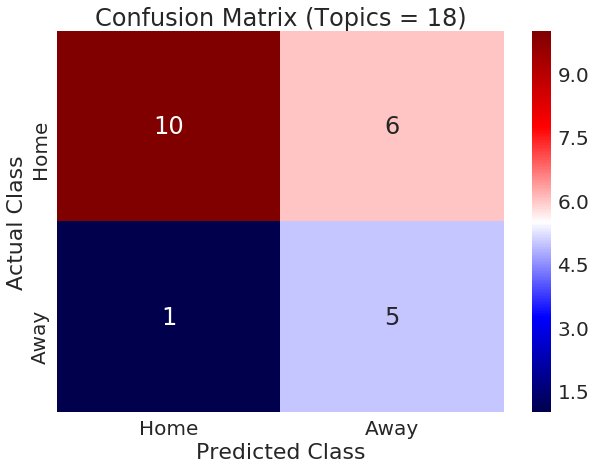

In [161]:
import seaborn as sn
labels = ["Home", "Away"]
sn.set(font_scale = 2)
print (matrix)
cm = pd.DataFrame(result_cm)
plt.figure(figsize = (10,7))
plt.title("Confusion Matrix (Topics = 18)")
ax = sn.heatmap(cm, cmap = "seismic", annot=True, xticklabels = labels, yticklabels = labels)
ax.set(ylabel = "Actual Class", xlabel = "Predicted Class");
plt.savefig('Normal_cm.png', bbox_inches='tight')